In [312]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter
import simpy
import random
import time 
import pandas as pd
import csv

In [313]:
class Location:
    def __init__(self, name=None, distance=None):
        self.name = name
        self.distance = distance

In [314]:
class Call:
    id_call = 0 
    def __init__(self, ID=None, initial_time=None, final_time=None, status=None, location=None):
        Call.id_call = Call.id_call + 1
        self.ID = Call.id_call
        self.initial_time = initial_time
        self.final_time = final_time
        self.status = status 
        self.location = location
         
        
    def detail(self):
        print('Call from {} received at {}'.format(self.location.name, self.initial_time))
        
    def generate_Call(self, env, beta, distance, p, counter, boat_list, lastCall=None):
        self.location = Location()
        self.location.name = random.choices([*distance], p)[0]
        #self.location.distance = distance[' '.join(self.location.name)]
        self.location.distance = distance[self.location.name]

        if (lastCall==None):
            self.initial_time = float (np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)
        else:    
            self.initial_time = float (lastCall.initial_time + np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)

        print('%7.4f Call %d received from %s at a distance of %d' % (env.now, self.ID, self.location.name, self.location.distance))
        
        with counter.request() as req:
            yield req
            wait = env.now - self.initial_time #waiting time 
            print('%7.4f Call %d: Waited %6.3f' % (env.now, self.ID, wait))
            yield env.process(trajet(env, boat_list, self, wait))
            print('%7.4f Call %d: Finished' % (env.now, self.ID))

        self.status = 1
        

In [315]:
def trajet(env, boat_list, call, wait): 
    i = 0 
    while(i != len(boat_list) and boat_list[i].status != 0): #while you don't have a boat available 
        i = i + 1
    if(i != len(boat_list) and boat_list[i].status == 0): #if you have a boat available
        boat_list[i].status = 1 
        intervention = Intervention()
        print('Boat {} with a speed of {} respond to the call {} '.format(boat_list[i].ID, boat_list[i].speed, call.ID))
        intervention.boat = boat_list[i]
        intervention.call = call
        intervention.travel_time = call.location.distance/boat_list[i].speed
        intervention.TOS = 0.25
        intervention.waited_time = wait 
        intervention.response_time = intervention.travel_time + wait 
        intervention.road_time = 2*intervention.travel_time + intervention.TOS 
        inter_list.append(intervention)
        yield env.timeout(intervention.road_time)
        call.final_time = call.initial_time + intervention.road_time 
        print('Duration of the intervention {} : {} '.format(intervention.ID, intervention.road_time))
        boat_list[i].status = 0
    

In [316]:
class Intervention: 
    nb_inter = 0 
    def __init__(self, travel_time=None, TOS=None, response_time=None, road_time = None, waited_time=None, boat=None, call=None):
        Intervention.nb_inter = Intervention.nb_inter + 1 
        self.ID = Intervention.nb_inter
        self.travel_time = travel_time
        self.TOS = TOS
        self.response_time = response_time 
        self.road_time = road_time 
        self.waited_time = waited_time 
        self.boat = boat
        self.call = call
        
    def to_dict(self): 
        return {
            'ID intervention': self.ID,
            'Boat associated': self.boat.ID,
            'Call traited': self.call.ID,
            'Call location': self.call.location.name, 
            'travel time': self.travel_time,
            'Time On Scene': self.TOS,
            'response time': self.response_time,
            'waited time': self.waited_time,
            'total time': self.road_time, 
        }

In [317]:
class Boat: 
    nb_boat = 0 
    def __init__(self, env, speed=None, status=None): 
        Boat.nb_boat = Boat.nb_boat + 1 
        self.ID = Boat.nb_boat 
        self.speed = speed 
        self.status = status 

In [318]:
def source(env, counter, p): 
    yield env.timeout(0)
    print('%7.4f Start' % (env.now))
    for i in range(nb_call):
        call_list.append(Call())
        if i == 0: 
            env.process(call_list[i].generate_Call(env, 38, distance, p, counter, boat_list))
        else: 
            env.process(call_list[i].generate_Call(env, 38, distance, p, counter, boat_list, call_list[i-1]))

In [319]:
#Define the variables
p_2015 = [0.07246376812, 0.03623188406, 0.02898550725, 0.05797101449, 0.007246376812, 0.1086956522, 0.007246376812, 0.1449275362, 0.1231884058, 0.04347826087, 0.04347826087, 0.09420289855, 0.04347826087, 0.1231884058, 0.0652173913]
p_2016 = [0.04255319149, 0.01418439716, 0.007092198582, 0.07092198582, 0.04964539007, 0.09929078014, 0.01418439716, 0.06382978723, 0.09929078014, 0.09219858156, 0.134751773, 0.07092198582, 0.03546099291, 0.1843971631, 0.02127659574]
distance = {'N SRA CARMO':100, 'N SRA P. SOCORRO':90, 'BONSUCESSO':80, 'ASS. NAZARE':70, 'GUAJARA':60, 
            'ARUAU':100, 'MIPINDIAU':90, 'CUIEIRAS':75, 'SANTA MARIA':60, 'JARAQUI':52, 'COSTA DOS ARARAS':50, 
            'COSTA DO TATU':30, 'AGROVILA':20, 'N. SRA. FATIMA':15, 'LIVRAMENTO':15}
nb_boat = 1
nb_call = 164
call_list = []
boat_list = []
inter_list = []

In [320]:
#Setup and lauch of the simulation 
def model():
    env = simpy.Environment()
    for i in range(nb_boat): 
        boat_list.append(Boat(env,50,0))
        #boat_list.append(Boat(env,30,0))
    counter = simpy.Resource(env, capacity=nb_boat)
    env.process(source(env, counter, p_2015))
    env.run()

for i in range(10): 
    
# print ("list of intervention")
# for inter in inter_list: 
#     print("Intervention {} : for call {} with boat {} take {} ".format(inter.ID, inter.call.ID, inter.boat.ID, inter.road_time))

 0.0000 Start
49.7784 Call 1 received from LIVRAMENTO at a distance of 15
49.7784 Call 1: Waited  0.000
Boat 1 with a speed of 50 respond to the call 1 
Duration of the intervention 1 : 0.85 
50.6284 Call 1: Finished
141.1192 Call 2 received from COSTA DOS ARARAS at a distance of 50
141.1192 Call 2: Waited  0.000
Boat 1 with a speed of 50 respond to the call 2 
141.7686 Call 3 received from SANTA MARIA at a distance of 60
Duration of the intervention 2 : 2.25 
143.3692 Call 2: Finished
143.3692 Call 3: Waited  1.601
Boat 1 with a speed of 50 respond to the call 3 
Duration of the intervention 3 : 2.65 
146.0192 Call 3: Finished
169.2889 Call 4 received from SANTA MARIA at a distance of 60
169.2889 Call 4: Waited  0.000
Boat 1 with a speed of 50 respond to the call 4 
Duration of the intervention 4 : 2.65 
171.9389 Call 4: Finished
215.6897 Call 5 received from AGROVILA at a distance of 20
215.6897 Call 5: Waited  0.000
Boat 1 with a speed of 50 respond to the call 5 
Duration of the in

In [321]:
df = pandas.DataFrame.from_records([inter.to_dict() for inter in inter_list])
df 

,Boat associated,Call location,Call traited,ID intervention,Time On Scene,response time,total time,travel time,waited time
0,1,LIVRAMENTO,1,1,0.25,0.300000,0.85,0.30,0.000000
1,1,COSTA DOS ARARAS,2,2,0.25,1.000000,2.25,1.00,0.000000
2,1,SANTA MARIA,3,3,0.25,2.800606,2.65,1.20,1.600606
3,1,SANTA MARIA,4,4,0.25,1.200000,2.65,1.20,0.000000
4,1,AGROVILA,5,5,0.25,0.400000,1.05,0.40,0.000000
5,1,ARUAU,6,6,0.25,2.000000,4.25,2.00,0.000000
6,1,ASS. NAZARE,7,7,0.25,1.400000,3.05,1.40,0.000000
7,1,SANTA MARIA,8,8,0.25,1.200000,2.65,1.20,0.000000
8,1,SANTA MARIA,9,9,0.25,1.200000,2.65,1.20,0.000000
9,1,N SRA CARMO,10,10,0.25,2.000000,4.25,2.00,0.000000


In [322]:
with open('intervention.csv', 'w', newline='') as csvfile:
    fieldnames = ['ID_intervention', 'boat_associated', 'call_traited', 'travel_time', 'response_time', 'time_on_scene', 'waited_time', 'total_time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, dialect='excel', delimiter=';')

    writer.writeheader()
    for inter in inter_list: 
        writer.writerow({'ID_intervention': inter.ID, 'boat_associated': inter.boat.ID, 'call_traited': inter.call.ID, 
                        'travel_time': inter.travel_time, 'response_time': inter.response_time, 'time_on_scene': inter.TOS,
                        'waited_time': inter.waited_time, 'total_time': inter.road_time})

In [323]:
df.to_csv('test.csv', sep = ";")

In [324]:
#data statistic 

sum_wait = 0
sum_travel_time = 0
sum_response_time = 0 
sum_road_time = 0 
for inter in inter_list: 
    sum_wait = sum_wait + inter.waited_time 
    sum_travel_time = sum_travel_time + inter.travel_time
    sum_response_time = sum_response_time + inter.response_time 
    sum_road_time = sum_road_time + inter.road_time 
    
mean_wait = sum_wait / len(inter_list)
mean_travel_time = sum_travel_time / len(inter_list)
mean_response_time = sum_response_time / len(inter_list)
mean_road_time = sum_road_time / len(inter_list)

print("le temps d'attente moyen est {} ".format(mean_wait))
print("le temps de trajet moyen est {} ".format(mean_travel_time))
print("le temps de réponse moyen est {} ".format(mean_response_time))
print("le temps total d'intervention moyen est {} ".format(mean_road_time))

print(df["Call location"].value_counts() / nb_call)

le temps d'attente moyen est 0.11284484956887679 
le temps de trajet moyen est 1.2480487804878047 
le temps de réponse moyen est 1.3608936300566814 
le temps total d'intervention moyen est 2.7460975609756093 
ARUAU               0.164634
CUIEIRAS            0.152439
SANTA MARIA         0.121951
N. SRA. FATIMA      0.097561
N SRA CARMO         0.091463
LIVRAMENTO          0.079268
COSTA DO TATU       0.073171
ASS. NAZARE         0.048780
JARAQUI             0.042683
COSTA DOS ARARAS    0.036585
BONSUCESSO          0.024390
AGROVILA            0.024390
N SRA P. SOCORRO    0.024390
GUAJARA             0.018293
Name: Call location, dtype: float64


Mean : 40.93725412717676  Max : 301.2831965868378  Min : 0.0582656129163297


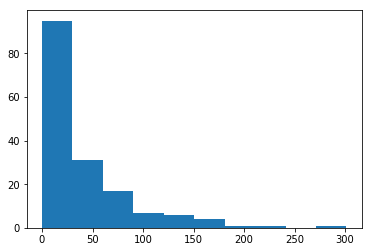

In [325]:
gaps = []
gaps.append(call_list[0].initial_time)
for i in range (1,len(call_list)-1):
    gaps.append(call_list[i].initial_time-call_list[i-1].initial_time)
    
mean_gaps = sum(gaps)/len(gaps)
print("Mean : {}  Max : {}  Min : {}".format(mean_gaps, max(gaps), min(gaps)))
    
plt.hist(gaps)
plt.show()

In [326]:
location = ['N SRA CARMO', 'N SRA P. SOCORRO', 'BONSUCESSO', 'ASS. NAZARE'] 
p = [0.7, 0.05, 0.05, 0.2]
distance = {'N SRA CARMO':100, 'N SRA P. SOCORRO':90, 'BONSUCESSO':80, 'ASS. NAZARE':70}
loc = []

for i in range (100):
    loc.append(random.choices([*distance], p)[0])

pd.Series(loc).value_counts()



N SRA CARMO         70
ASS. NAZARE         24
BONSUCESSO           3
N SRA P. SOCORRO     3
dtype: int64